## Maxout on CIFAR-10

This notebook demonstrates a "maxout" type NN as presented in

[Goodfellow, I. J., Warde-Farley, D., Mirza, M., Courville, A. C., & Bengio, Y. (2013). Maxout Networks. ICML'13, 28, 1319-1327.](http://www-etud.iro.umontreal.ca/~goodfeli/maxout.html)

using Keras.

The network structure was mostly copied from https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/cifar10_no_aug.yaml (which corresponds with the paper), though not all preprocessing, regularization, or optimizer settings are the same. As a result of these differences, the performance of this network is somewhat worse than what is presented in the paper.

Note: I haven't actually run this to completion as my GPU doesn't have enough memory and it's about 60 minutes an epoch on my CPU.

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [6]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import backend as K

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = (32,32,3)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape)

(50000, 32, 32, 3)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv_1_0 (Conv2D)                (None, 32, 32, 96)    18528                                        
____________________________________________________________________________________________________
conv_1_1 (Conv2D)                (None, 32, 32, 96)    18528                                        
___________________________________________________________________________________________

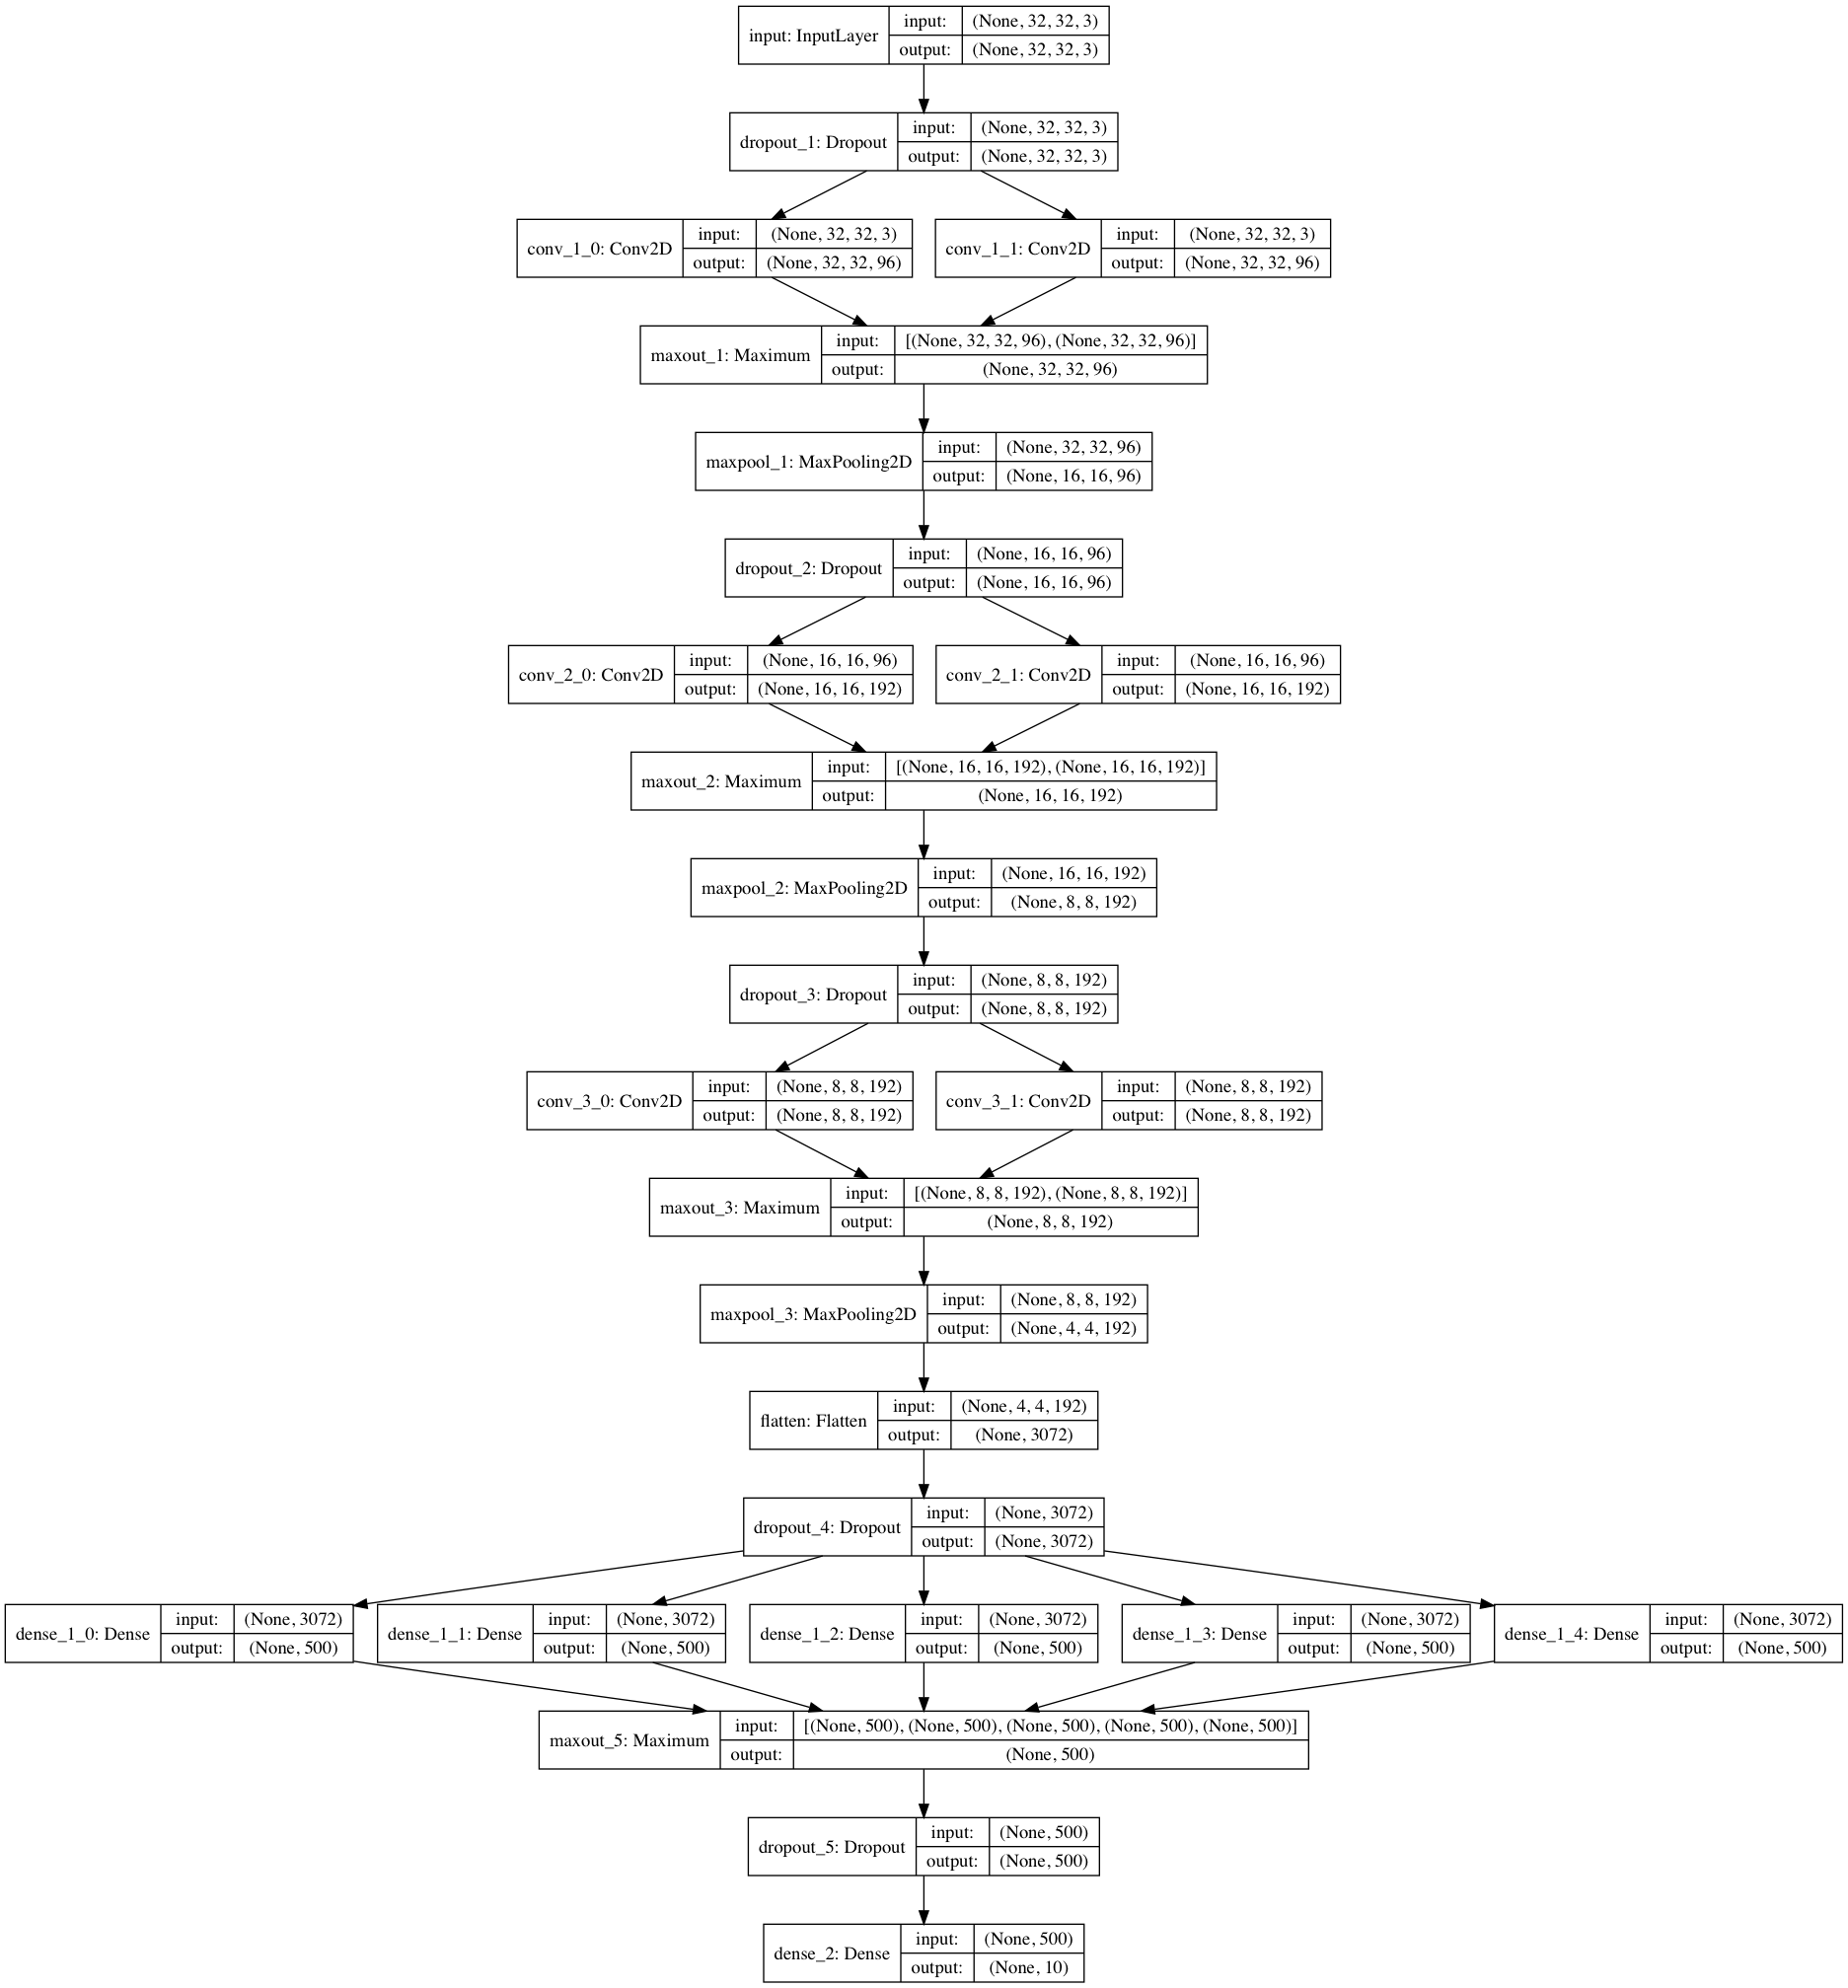

In [8]:
def maxout(input_shape):
    inputs = layers.Input(shape = input_shape, name='input')
    
    x = layers.Dropout(0.8, name='dropout_1')(inputs)
    x = layers.Maximum(name='maxout_1')([
        layers.Conv2D(96, kernel_size = (8,8), padding = 'same', name='conv_1_{}'.format(i))(x)
        for i in range(2)
    ])
    x = layers.MaxPool2D(name='maxpool_1')(x)
    
    x = layers.Dropout(0.8, name='dropout_2')(x)
    x = layers.Maximum(name='maxout_2')([
        layers.Conv2D(192, kernel_size = (8,8), padding = 'same', name='conv_2_{}'.format(i))(x)
        for i in range(2)
    ])
    x = layers.MaxPool2D(name='maxpool_2')(x)
    
    x = layers.Dropout(0.8, name='dropout_3')(x)
    x = layers.Maximum(name='maxout_3')([
        layers.Conv2D(192, kernel_size = (5,5), padding = 'same', name='conv_3_{}'.format(i))(x)
        for i in range(2)
    ])
    x = layers.MaxPool2D(name='maxpool_3')(x)
    
    x = layers.Flatten(name='flatten')(x)
    
    x = layers.Dropout(0.8, name='dropout_4')(x)
    x = layers.Maximum(name='maxout_5')([
        layers.Dense(500, name='dense_1_{}'.format(i))(x)
        for i in range(5)
    ])
    
    x = layers.Dropout(0.8, name='dropout_5')(x)
    predictions = layers.Dense(10, activation='softmax', name='dense_2')(x)
    
    model = Model(inputs = inputs, outputs = predictions)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer= optimizers.sgd(lr=.17, momentum=0.5),
                  metrics=['accuracy'])
    return model

maxout_model = maxout(input_shape)
    
    
Image(model_to_dot(maxout_model, show_shapes=True).create_png(prog='dot'))

<IPython.core.display.Javascript object>


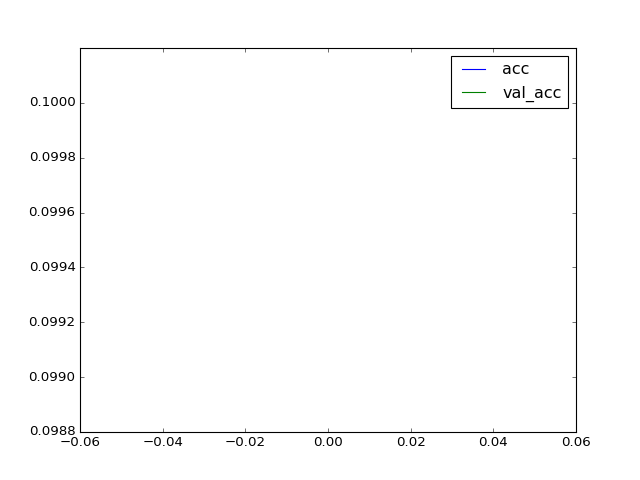

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6920s - loss: 14.5230 - acc: 0.0989 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/50
14208/50000 [=======>......................] - ETA: 4612s - loss: 14.5299 - acc: 0.0985

In [ ]:
def plot_progress(statistics=['acc', 'val_acc']):
    fig = plt.figure()
    plt.ion()

    fig.show()
    ax = fig.add_subplot(111)
    fig.canvas.draw()
 
    data = [[] for s in statistics]
    
    def plot_progress_helper(i, logs):
        ax.set_prop_cycle(None)
        for s, xs in zip(statistics, data):
            xs.append(logs[s])
            ax.plot(xs)
        plt.legend(statistics)
        fig.canvas.draw()
    
    return plot_progress_helper

history = maxout_model.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 50,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [
        keras.callbacks.LambdaCallback(on_epoch_end=plot_progress())
    ]
)

score = maxout_model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])